In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

Change figsize to control relative font size and aspect ratio. Increase DPI for higher resolution.

In [26]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 100

## Reading data

In [27]:
row_start = 14

In [11]:
metadata = dict()
filename = "gaussian/T0008ALL.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '1e-05',
 'Sample Interval': '1e-09',
 'Filter Frequency': '2e+08',
 'Record Length': '100000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '0.5',
 'Label': ''}

In [12]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH3
0,0.01295,0.02,0.01
1,0.01295,0.02,0.03
2,0.01295,0.02,0.01
3,0.01295,0.02,0.03
4,0.01295,0.02,0.03
...,...,...,...
99995,0.01305,0.04,0.01
99996,0.01305,0.02,0.01
99997,0.01305,0.02,0.01
99998,0.01305,0.02,0.01


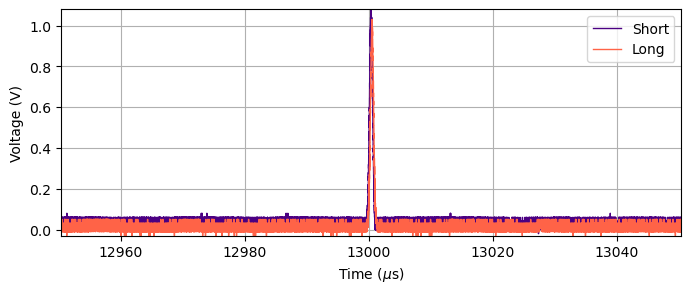

In [247]:
t_raw = data["TIME"].to_numpy()*1e6
ch1_raw = data["CH1"].to_numpy()
ch2_raw = data["CH3"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Short",
    c="indigo",
    lw=1
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Long",
    c="tomato",
    lw=1
)
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Voltage (V)")
plt.grid()
plt.margins(0)
plt.legend()

## Fitting data

In [236]:
near = np.abs(t_raw - t_raw[np.argmax(ch2_raw)])
select = near < 2
antiselect = np.logical_and(near > 3, near < 1000)

t = t_raw[select]
t -= np.mean(t)
dt = np.average(np.diff(t))

ch1_noisy = ch1_raw[select] - np.mean(ch1_raw[antiselect])
ch2_noisy = ch2_raw[select] - np.mean(ch2_raw[antiselect])

ch1 = sp.signal.savgol_filter(ch1_noisy, 10, 3)
ch2 = sp.signal.savgol_filter(ch2_noisy, 10, 3)

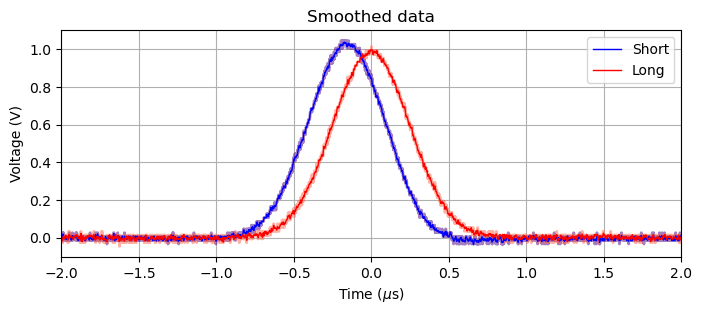

In [237]:
plt.title("Smoothed data")
plt.plot(t, ch1_noisy, lw=2, alpha=0.5, c="indigo")
plt.plot(t, ch2_noisy, lw=2, alpha=0.5, c="tomato")

plt.plot(t, ch1, label="Short", lw=1, c="blue")
plt.plot(t, ch2, label="Long", lw=1, c="red")

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Voltage (V)")
plt.grid()
plt.legend()
plt.xlim(-2,2)

plt.show()

In [238]:
## Gaussian curve
curve = lambda t, A, g: A / np.exp((t/g)**2)

double = lambda t, A, g, h, x, y: curve(t-x, A, g) + curve(t-y, A, h)
delayed = lambda t, A, g, x: curve(t-x, A, g)

In [254]:
[[A1, g1, x1], cov1] = sp.optimize.curve_fit(delayed, t, ch1, p0=[1, 0.34, -0.1])
[[A2, g2, x2], cov2] = sp.optimize.curve_fit(delayed, t, ch2, p0=[1, 0.34, -0.0])

# Curves fit to channels
fit1 = delayed(t, A1, g1, x1)
fit2 = delayed(t, A2, g2, x2)

{
    "Cable": ("Short", "Long"),
    "Amplitude (V)": (A1, A2),
    "Spread (us)": (g1, g2), 
    "Offset (us)": (x1, x2)
}

{'Cable': ('Short', 'Long'),
 'Amplitude (V)': (1.0323886753614444, 0.98406922061418),
 'Spread (us)': (0.3435567430294667, 0.354683197613662),
 'Offset (us)': (-0.16094576300640925, -0.00235976845433214)}

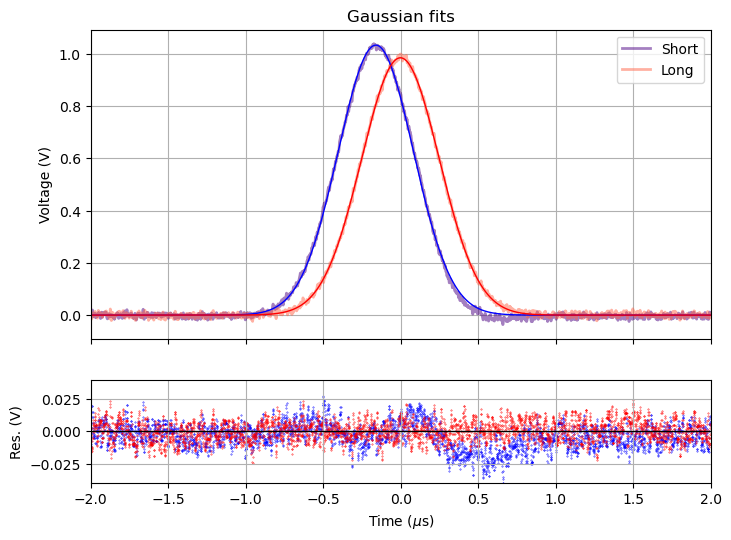

In [255]:
fig, [ax1, ax2] = plt.subplots(2,1,sharex=True,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})

plt.sca(ax1)
plt.title("Gaussian fits")
plt.plot(t, ch1, label="Short", lw=2, c="indigo", alpha=0.5)
plt.plot(t, ch2, label="Long", lw=2, c="tomato", alpha=0.5)

plt.plot(t, fit1, lw=1, c="blue")
plt.plot(t, fit2, lw=1, c="red")

plt.ylabel("Voltage (V)")
plt.xlim(-2,2)

plt.grid()
plt.legend()

plt.sca(ax2)
res1 = ch1 - fit1
res2 = ch2 - fit2
maxres = np.max(np.abs(np.concatenate((res1, res2))))
plt.ylim(-maxres, maxres)
plt.ylabel("Res. (V)")
plt.scatter(t, res1, s=0.1, c="blue")
plt.scatter(t, res2, s=0.1, c="red")
plt.axhline(0, c="black", lw=1)
plt.grid()

plt.xlabel("Time ($\mu$s)")
plt.show()

## Dispersion analysis

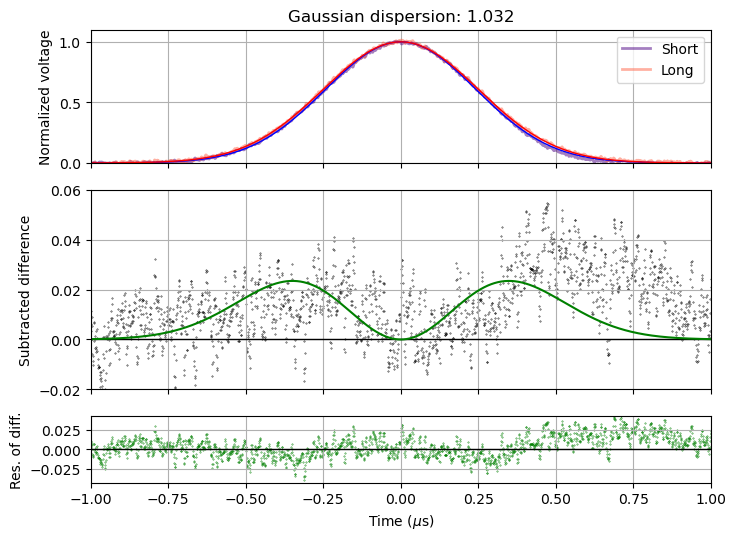

In [256]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,sharex=True,figsize=(8,6),gridspec_kw={'height_ratios': [2, 3, 1]})

shift1 = -int(x1/dt)
shift2 = -int(x2/dt)
ret = t[shift1:-shift2] - x2
re1 = ch1[shift2:-shift1] / A1
re2 = ch2[shift1:-shift2] / A2

plt.sca(ax1)
plt.title(f"Gaussian dispersion: {g2/g1:.3f}")
plt.plot(ret, re1, c="indigo", label="Short", lw=2, alpha=0.5)
plt.plot(ret, re2, c="tomato", label="Long", lw=2, alpha=0.5)
plt.plot(t, curve(t, 1, g1), lw=1, c="blue")
plt.plot(t, curve(t, 1, g2), lw=1, c="red")
plt.ylim(0,1.1)
plt.xlim(-1,1)
plt.ylabel("Normalized voltage")
plt.grid()
plt.legend()

plt.sca(ax2)
plt.axhline(0, c="black", lw=1)
plt.ylabel("Subtracted difference")
plt.plot(ret, curve(ret, 1, g2) - curve(ret, 1, g1), c="green")
plt.scatter(ret, re2 - re1, s=0.1, c="black")
plt.grid()
plt.ylim(-0.02,0.06)

plt.sca(ax3)
plt.axhline(0, c="black", lw=1)
resdiff = (re2 - re1) - (curve(ret, 1, g2) - curve(ret, 1, g1))
maxres = np.max(np.abs(resdiff))
plt.ylim(-maxres, maxres)
plt.ylabel("Res. of diff.")
plt.scatter(ret, resdiff, s=0.1, c="green")
plt.grid()

plt.xlabel("Time ($\mu$s)")

plt.show()

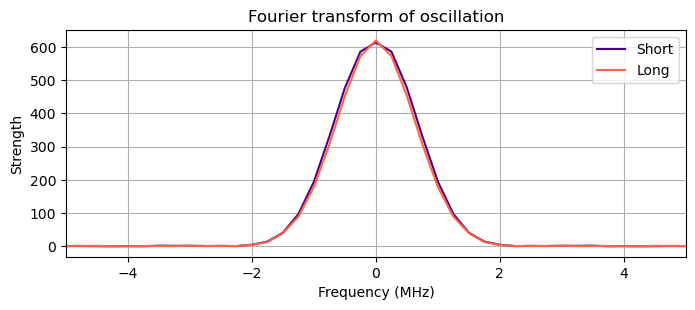

In [265]:
from scipy.fft import fft, fftfreq, fftshift

for (n, ch) in enumerate([ch1, ch2]):
    spectrum = np.abs(fftshift(fft(ch)))
    # spectrum /= np.max(spectrum)
    sampling_rate = 1 / dt
    freq = fftshift(fftfreq(t.size, 1/sampling_rate))
    bin_width = np.average(np.diff(freq))
    plt.plot(freq, spectrum, label=("Short" if n==0 else "Long"), c=("indigo" if n==0 else "tomato"))

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Strength")
plt.xlim(-5, 5)
# plt.ylim(0, 1.1)
plt.grid()
plt.legend()
plt.show()